In [1]:
#_____import packages______
from astropy.io import fits
import numpy as np
import math
import time
import sys
from astropy.table import Table
from astropy import constants as const
from astropy import units as u    
from galpy.util import bovy_coords, bovy_conversion

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import rcParams 
rcParams['font.size'] = 16

In [2]:
#_____read in data_____
hdul = fits.open('../../Gaia/Gaia_data_for_Sophia_temp.fits')
tbdata = hdul[1].data

In [3]:
random_index = tbdata.field('random_index')  
vx_HC_kms = tbdata.field('U_HC_kms')
vy_HC_kms = tbdata.field('V_HC_kms')
vz_HC_kms = tbdata.field('W_HC_kms')
U_LSR_kms = tbdata.field('U_LSR_kms')
V_LSR_kms = tbdata.field('V_LSR_kms')
W_LSR_kms = tbdata.field('W_LSR_kms')
R_kpc = tbdata.field('R_GC_kpc')
phi_rad = tbdata.field('phi_GC_rad')
z_kpc = tbdata.field('z_GC_kpc')
vR_kms = tbdata.field('vR_GC_kms')
vT_kms = tbdata.field('vT_GC_kms')
vz_kms = tbdata.field('vz_GC_kms')

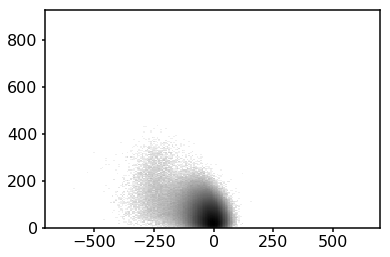

In [4]:
Toomre_x = V_LSR_kms
Toomre_y = np.sqrt(U_LSR_kms**2 + W_LSR_kms**2)
fig,ax = plt.subplots()
ax.spines['top'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)
ax.hist2d(Toomre_x, Toomre_y, bins = 201, norm = colors.LogNorm(), cmap = plt.cm.binary)
plt.show()

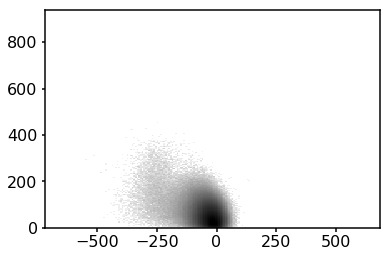

In [5]:
toomre_x = vy_HC_kms
toomre_y = np.sqrt(vx_HC_kms**2 + vz_HC_kms**2)

fig,ax = plt.subplots()
ax.spines['top'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)


ax.hist2d(toomre_x, toomre_y, bins = 201, norm = colors.LogNorm(), cmap = plt.cm.binary)
#ax.set_xlabel('v$_\mathrm{}')
plt.show()

In [6]:
const.G

<<class 'astropy.constants.codata2014.CODATA2014'> name='Gravitational constant' value=6.67408e-11 uncertainty=3.1e-15 unit='m3 / (kg s2)' reference='CODATA 2014'>

In [7]:
from galpy.potential import LogarithmicHaloPotential, MiyamotoNagaiPotential, HernquistPotential, MWPotential2014, evaluatePotentials
import McMillan

  Referenced from: /Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy_interppotential_c.cpython-36m-darwin.so
  Reason: image not found' 
/Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy/potential/DiskSCFPotential.py:190: RuntimeWarning: divide by zero encountered in double_scalars
  ts= lambda R, trd=rd, trm=rm: numpy.exp(-trm/R-R/trd)

/Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy/potential/DiskSCFPotential.py:194: RuntimeWarning: divide by zero encountered in double_scalars
  ((trm/R**2.-1./trd)**2.-2.*trm/R**3.)*numpy.exp(-trm/R-R/trd)

/Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy/potential/DiskSCFPotential.py:194: RuntimeWarning: invalid value encountered in double_scalars
  ((trm/R**2.-1./trd)**2.-2.*trm/R**3.)*numpy.exp(-trm/R-R/trd)

/Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy/potential/DiskSCFPotential.py:477: RuntimeWarning: divide by zero encountered in double_scalars
  out-= a*(s(r)*h(z)+d2s(r)*H(z)+2./r*ds(r)

In [19]:
##### halo selection according to Helmi et al 10.2018
# abs(V - V_LSR) > 210 km/s
# -1500 kpc km/s < L_z < 150 kpc km/s
# E > -1.8 x 10^5 km^2 / s^2

# velocity cut (subtract v_LSR from v_T)
v_GC_cut = np.sqrt(vR_kms**2 + (vT_kms-232.)**2 + vz_kms**2)
halo_v_cut = (v_GC_cut > 210.)


# angular momentum cut
L_z_kpckm_s = R_kpc * vT_kms

halo_L_cut = (L_z_kpckm_s > -1500.) * (L_z_kpckm_s < 150.)

# energy cut 
# need to make a potential first

def potential(R, z, v_halo = 222.2, d = 12., M_disk = 6.3, a_d = 6.5, b_d = 0.26, M_bulge = 2.1, c_b = 0.7):
    r = np.sqrt(R**2 + z**2)
    Phi_halo  = (v_halo * u.km/u.s) **2. * np.log(1 + ((R * u.kpc)**2 / (d * u.kpc)**2) + ((z * u.kpc)**2 / (d * u.kpc)**2)) #km^2/s^2
    Phi_disk  = - const.G * M_disk * 1e10 * u.Msun / np.sqrt((R * u.kpc)**2 + (a_d * u.kpc + np.sqrt((z*u.kpc)**2 + (b_d * u.kpc)**2))**2)
    Phi_bulge = - const.G * M_bulge *1e10 * u.Msun / (r * u.kpc + c_b * u.kpc)
    Phi_tot = Phi_halo + Phi_bulge + Phi_disk
    return(Phi_tot)


def galpy_potential(R,z):
    R0 = 8.
    V0 = 232.
    MW14 = McMillan.McMillan2017
    #MW14.turn_physical_on()
    pot = evaluatePotentials(MW14, R/R0, z/R0) * V0**2 * u.km**2 / u.s**2
    return(pot)
    
pot = potential(R_kpc,z_kpc)
    
#calculate potential of the stars
print('start potential calculation')
#for i, item in enumerate(R_kpc):
    #pot = potential(item, z_kpc[i])
#pot_galpy = galpy_potential(R_kpc, z_kpc)
print('potential calculated')
#calculate total velocity of the stars
v_GC_tot = vR_kms**2 + vT_kms**2 + vz_kms**2

E_km2_s2 = 0.5 * (v_GC_tot * u.km**2/u.s**2) + pot#_galpy

halo_E_cut = E_km2_s2 > (-1.8 * 1e5 * u.km**2 / u.s**2)

start potential calculation
potential calculated


In [20]:
#pot_galpy

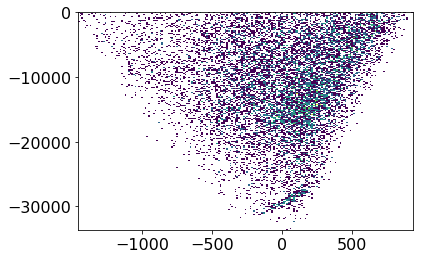

In [21]:
plt.hist2d(L_z_kpckm_s[(v_GC_cut > 210.) * (E_km2_s2<0.)], E_km2_s2[(v_GC_cut > 210.) * (E_km2_s2<0.)], bins = 201, norm = colors.LogNorm())
plt.show()

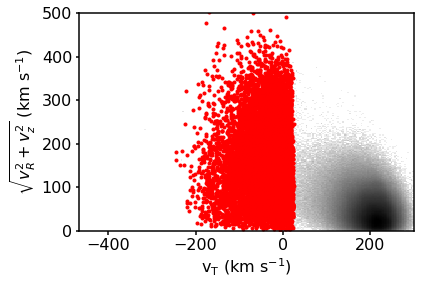

In [340]:
toomre_x_galcen = vT_kms
toomre_y_galcen = np.sqrt(vR_kms**2 + vz_kms**2)

ence_cut = halo_v_cut * halo_L_cut * halo_E_cut

cut = (toomre_x_galcen < 300.) * (toomre_y_galcen < 500.)
fig,ax = plt.subplots()
ax.spines['top'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)

ax.hist2d(toomre_x_galcen[cut], toomre_y_galcen[cut], bins = 201, norm = colors.LogNorm(), cmap = plt.cm.binary)
ax.plot(toomre_x_galcen[ence_cut], toomre_y_galcen[ence_cut], 'r.')
ax.set_xlabel('v$_\mathrm{T}$ (km s$^{-1}$)')
ax.set_ylabel('$\sqrt{v_R^2 + v_z^2}$ (km s$^{-1}$)')

plt.show()


In [135]:
## read in Helmi's data for Fig 1
source_id,vx,vy,vz,En,Lz,flag = np.genfromtxt('../../Gaia/41586_2018_625_MOESM1_ESM.csv', delimiter=',', unpack=True, skip_header=1)

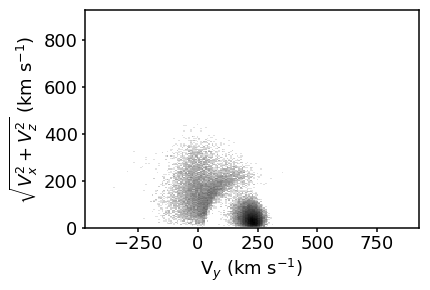

In [209]:
fig,ax = plt.subplots()
ax.spines['top'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)

ax.hist2d(vy, y_toomre, bins = 201, norm = colors.LogNorm(), cmap = plt.cm.binary)
ax.set_xlabel('V$_y$ (km s$^{-1}$)')
ax.set_ylabel('$\sqrt{V_x^2 + V_z^2}$ (km s$^{-1}$)')

plt.show()

In [14]:
v_cut = np.sqrt(vx**2 + (vy-232.)**2 + vz**2)
halo_cut = (v_cut > 210.)
plt.hist2d(Lz[halo_cut * (En<0.)], En[halo_cut * (En<0.)], bins = 201, norm = colors.LogNorm())
plt.show()

NameError: name 'vx' is not defined

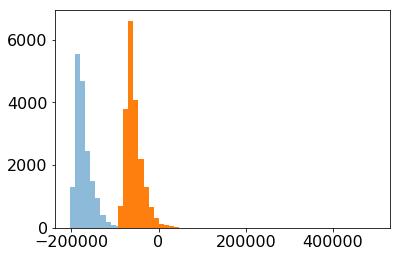

In [351]:
plt.hist(En[halo_cut], bins = 51, alpha = 0.5)
plt.hist(np.array(E_km2_s2)[halo_v_cut], bins = 51)
plt.show()

(array([  5.05154000e+06,   2.70500000e+03,   5.90000000e+01,
          1.40000000e+01,   1.00000000e+01,   4.00000000e+00,
          1.00000000e+00,   5.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([ -37910.72709733,   20366.45290095,   78643.63289923,
         136920.81289751,  195197.99289579,  253475.17289407,
         311752.35289235,  370029.53289063,  428306.71288891,
         486583.89288718,  544861.07288546]),
 <a list of 10 Patch objects>)

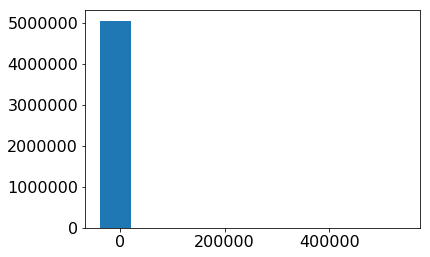

In [321]:
plt.hist(np.array(E_km2_s2))